In [79]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader


In [75]:
path_glah14 = 'data/icesat-1/GLAH14-2006/data-readout/GLAH14_634_2115_001_1317_0_01_0001_readout_subs.h5'
path_atl06 = 'data/icesat-2/ATL06-2018/data-readout/processed_ATL06_20181014210104_02480106_005_01_readout_subs.h5'
path_glah14_tile= 'data/icesat-1/GLAH14-2006/data-tiles/tile_29_98.h5'
tile_left, tile_right, tile_bottom, tile_up = 95, 96, 28, 29



In [76]:
!h5ls $path_glah14_tile


h                        Dataset {378}
lat                      Dataset {378}
lon                      Dataset {378}
orbit                    Dataset {378}
t_dyr                    Dataset {378}
track                    Dataset {378}


In [78]:
# with h5py.File(path_glah14,'r') as f_glah14:
#     lat = f_glah14['lat'][:]
#     lon = f_glah14['lon'][:]
f_glah14 = h5py.File(path_glah14_tile,'r')
lon, lat = f_glah14['lon'][:], f_glah14['lat'][:]



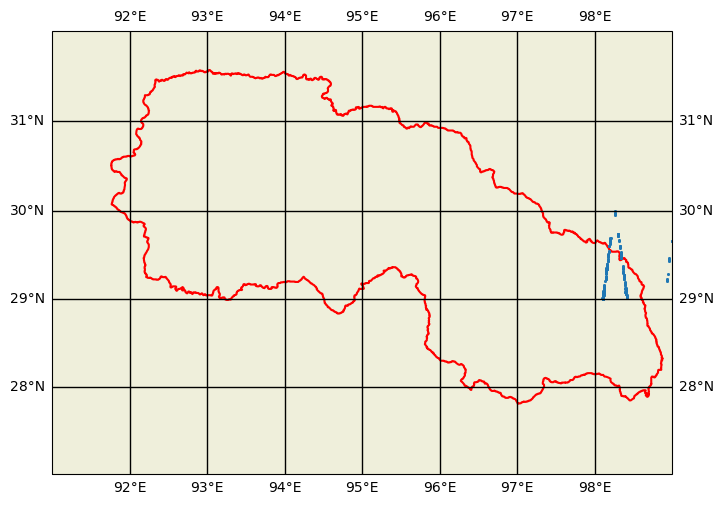

In [80]:

path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([91, 99, 27.0, 32.0])
ax.add_feature(cfeature.LAND); 
ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='black')
## 1. setp boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='red', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=0)
## 2. icesat-1 data
ax.scatter(x=lon, y=lat, s=1, transform=ccrs.PlateCarree(), zorder=0)

